# I) Summary

## <ins> 1) Introduction </ins>

- Recently, computer vision methods have leveraged large datasets to learn rich, high-performance visual representations.

- To scale these methods on Internet-scale datasets, human annotation is required.

- To address this difficulty, we need to use the data without any annotation (unsupervised learning).

- However, unsupervised methods can't yet extract useful information from large collections.

- Thus, **how can one build a model to capture objects if none of the objects are labeled?**

- Turns out, unsupervised representation learning can also be formulated as learning an embedding where images that are semanticallly similar are close, while semantically different ones are far apart. 

- One way to build such a representation is to create a supervised "pretext" task which will be used to generate useful feature representations.

---
<ins><b>Remark:</b></ins>

- Useful: Representation that should be easily adaptable for other tasks, unknown during training time.

- Pretext tasks: Pre-designed tasks for networks to solve, and visual features are learned by learning objective functions of pretext tasks.

---

## <ins> 2) Context Prediction in Image</ins>

In our case, the pretext task will be "context prediction".

Given unlabeled image, we randomly extract a patch (blue) and then one of its eight possible neighbors (red). <br>Then we train our ConvNet to predict the position of the red patch relative to the blue patch.

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685505316267229214/unknown.png" width="400">


- To do well on this pretext task, the model needs to learn to recognize objects and their parts.<br>
- They find that the features the network extract can be used to match patches semantically. <br>
- Indeed, the feature representation learned captures visual similarity accross images which allows us to discover objects like cats, people or birds.


Therefore, the goal of this task is to extract the semantic of an image. <br>
However, for some images, the ConvNets will find another way to solve the problem, called "trivial" shortcuts. <br>

#### <ins>1st trivial shortcut:</ins>

![](https://cdn.discordapp.com/attachments/676833120053493770/685795943739686924/unknown.png)

If the ConvNet is given the right part of the above image, it will easily find a solution of the problem due
to the continous line between the 2 patches.
<br>
To avoid this, the authors included a gap between patches (half the patch width), and randomly jittered each patch location by up to 7 pixels


<img src="https://cdn.discordapp.com/attachments/676833120053493770/685796814456356909/unknown.png" width="600">

#### <ins>2nd trivial shortcut:</ins>

The authors found that some patches retrieved matched patches from the same absolute location in the image, regardless of content, because those patches displayed similar chromatic aberration.


Chromatic aberration arises from differences in the way the lens focuses light at different wavelengths. In some cameras, one color channel (commonly green) is shrunk toward the image center relative to the others.


It turns out that the ConvNet can learn to localize a patch relative to the lens itself simply by detecting the separation between green and magenta (red + blue). 


Once the network learns the absolute location on the lens, solving the relative location task becomes trivial.

To fix this, 2 methods were proposed:

- Shift green and magenta toward gray.
- Randomly drop 2 of the 3 color channels from each patch replacing the dropped colors with Gaussian noise.

To sum up, we want to avoid these shortcuts and force the ConvNet to learn the semantic of the image instead.

<ins><b>Few comments:</b></ins>

However, the paper doesn't properly explain how to get the central patch blue.

The only information given is that we have to choose it randomly.

<ins><b>Suggestions:</b></ins>

Since no indications where given, here is my own method:

1. Pick an image that has at least 73,728 total pixels (this is the minimum number of pixels to have a 96x96 blue patch surrounded by 8 96x96 red squares with gap + jitter). <br> For example, the following image is (x, y) = (600, 800).
    - top left corner has coordinate (96 + gap + jitter, 96 + gap + jitter).
    - bottom right corner has coordinate (y - 96 - gap - jitter, x - 96 - gap - jitter).

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685937912994725908/iUfzAxqME9igexaP4gY1HCexRPIpH8QMbjxLYo3gUjIHNh4lsEfxKB7FD2z8P7SlV3upXceHAAAAAElFTkSuQmCC.png" width="300">
 
2. Define a green grid.
    - Green rectangle = grid without gap & jitter.
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/685937809340629113/syI7syP4O7MiBHdmRHdlPrB05sCM7siP7ibUjB3ZkR3ZkP7F25MCO7MiO7CfWjhzYkR3Zkf3E2v8D2dYkrJGIgyAAAAAASUVORK5.png" width="300">
    
3. Define a blue grid (represents every possible positions of the blue patch).
    - Blue rectangle = grid with gap & jitter.
    - Blue square = Blue patch of size 96x96.
    - By adding the jitter now, we only need to add jitter to red patches in the diagonal.
    
<img src="https://cdn.discordapp.com/attachments/676833120053493770/685936774463488122/AU4D2ClOcYrPLU4D2ClOcYrPLU4D2ClOcYrPLU4D2ClOcYrPLU4D2ClOcYrPLf4e46MTG3v9tIEAAAAASUVORK5CYII.png" width="300">

4. Draw the 8 red patches with gap + red patches in the diagonal.
    - For convenience, jitter should make the red patches in the diagonal "points" towards the blue patch.
<img src="https://cdn.discordapp.com/attachments/676833120053493770/685948044034048049/eeYooppvgNYBrApphiipcW0wA2xRRTvLSYBrApppjipcU0gE0xxRQvLaYBbIoppnhp8UvaK4mItPgorwAAAABJRU5ErkJggg.png" width="300">

6. Repeat the process for every possible blue patch positions.
    - Distance between 2 blue patches is equal to "gap".

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685949373707714570/unknown.png" width="300">


- Thus, for 1 blue patch, we will have 8 possibles batches. (1 batch = (blue patch, one of the 8 red squares)).


---
## <ins> 3) Architecture </ins>


Here is the architecture of the model:

![](https://cdn.discordapp.com/attachments/676833120053493770/685511157586460720/unknown.png)

- 2 AlexNet.
- All conv / fc have ReLU except fc9 which has softmax.
- input size = 96x96.

<ins><b>Few comments:</b></ins>

- There seems to be an error at conv2 (Orginal AlexNet uses 256 filters instead of 384). 
- Batch Normalization seems to [be prefered](https://stats.stackexchange.com/questions/145768/importance-of-local-response-normalization-in-cnn) over Local Response Normalization.
- No indication about padding value in the paper.
- fc7 seems to be built from the concatenation of the 2 fc6 layers. However, fc7 output size is 4096 and the 2 fc6 output sizes are 4096. Thus, after concatenation, fc7 output size will be 8192.

<ins><b>Suggestions:</b></ins>
- Use 256 filters at conv2.
- Remove LRN.
- Add Batch Normalization after every layers.
- Concatenate the 2 fc6.
---
## <ins> 4) Experiments </ins>

<b>a)</b> Nearest-Neighbor Matching. <br>
<b>b)</b> Object Detection.<br>
<b>c)</b> Geometry Estimation.<br>
<b>d)</b> Visual Data Mining.<br>

### <ins> a) Nearest-Neighbor Matching </ins>

The goal of this section is to understand which patches the network consider familiar.

To do so, we are going to compare the result of nearest-neighbor matching with:

- The network until fc6 after training with our method (denoted <b>A</b>).
    - Only one of the two stacks are used.
    - fc7 and higher layers are removed.
    - Normalized cross correlation is used to find similar patches.
    - Randomly selected 96x96 patches are used in the comparison.
- The network until fc6 untrained (random initialization) (denoted <b>B</b>).
- AlexNet until fc7 after training on labeled ImageNet (denoted <b>C</b>).

Here are the result:

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685851395416653824/unknown.png" width="600">

<ins><b>Conclusion:</b></ins>
The matches returned by <b>A</b> often capture the semantic information that we are after, matching <b>C</b> in terms of semantic content (in some cases, e.g. the car wheel, our matches capture pose better). 
<br>
But for some images, <b>C</b> performs better (e.g. keyboards).
<br>
Interestingly, in a few cases, <b>B</b> ConvNet also does reasonably well.

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685851878562594820/unknown.png" width="600">

### <ins> b) Object Detection </ins>

This section shows that the learned ConvNet (pretrained on unlabeled images) can be used in a R-CNN pipeline to detect objects.

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685857585072701633/unknown.png" width="600">

It was able to provide a significant boost over a ConvNet trained only on Pascal VOC dataset but still perfom less than a ConvNet trained on Imagenet Labels.

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685857924694016025/unknown.png" width="600">

### <ins> c) Geometry Estimation </ins>

This sections shows that our representation is sensitive to objects, even though it was not originally
trained to find them.

To prove the point, they fine-tuned the ConvNet to perform a surface normal estimation and the results are almost equivalent to those obtained using a fully-labeled ImageNet model

<img src="https://cdn.discordapp.com/attachments/676833120053493770/685862560683130925/unknown.png" width="500">

### <ins> d) Visual Data Mining </ins>

This section shows that given a large unlabeled dataset, the ConvNet was able to mined out objects.
It seems like the Nearest-Neighbor Matching approach is inedequate for this task.

---
## <ins> 4) Conclusion </ins>

The pretext task was to detect the position of a patch relative to a center patch. Turns out that in order to perform well on this task, it requires the model to learn to recognize objects and their parts.
This means that the model was able to extract the semantic of an image which seems to be useful to solve other problems (Nearest-Neighbor Matching, Object detection, Geometry Estimation and Visual Data Mining)
 

# II/ Implementation

- We will only implement the network and the function to extract pair of patches.

## 1) Build the Network

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchsummary import summary
from collections import OrderedDict

In [90]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        # Insert in Sequential().
        print(x.shape)
        return x
    
class AlexNet(nn.Module):
    
    def __init__(self, num_classes=8):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3,
                                96,
                                kernel_size=11,
                                stride=4,
                                padding=4)),
            ('act1', nn.ReLU()),
            ('bn1', nn.BatchNorm2d(96)),
            ('pool1', nn.MaxPool2d(3, stride=2)),
            ('conv2', nn.Conv2d(96,
                                256,
                                kernel_size=5,
                                stride=1,
                                padding=2)),
            ('act2', nn.ReLU()),
            ('bn2', nn.BatchNorm2d(256)),
            ('pool2', nn.MaxPool2d(3, stride=2)),
            ('conv3', nn.Conv2d(256,
                                384, 
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('act3', nn.ReLU()),
            ('bn3', nn.BatchNorm2d(384)),
            ('conv4', nn.Conv2d(384,
                                384,
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('act4', nn.ReLU()),
            ('bn4', nn.BatchNorm2d(384)),
            ('conv5', nn.Conv2d(384,
                                256,
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('act5', nn.ReLU()),
            ('bn5', nn.BatchNorm2d(256)),
            ('pool5', nn.MaxPool2d(3, stride=2)),
            ('flatten', nn.Flatten()),
            ('fc6', nn.Linear(1024, 4096)),
            ('act6', nn.ReLU()),
            ('bn6', nn.BatchNorm1d(4096))
        ]))
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc7', nn.Linear(8192, 4096)),
            ('act7', nn.ReLU()),
            ('fc8', nn.Linear(4096, 4096)),
            ('act8', nn.ReLU()),
            ('fc9', nn.Linear(4096, num_classes))
        ]))
        
    def forward(self, input1, input2):
        patch1 = self.features(input1)
        patch2 = self.features(input2)
        patch = torch.cat([patch1, patch2], 1)
        out = self.classifier(patch)
        return out

In [91]:
model = AlexNet()
summary(model, [(3, 96, 96) , (3, 96, 96)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 24, 24]          34,944
              ReLU-2           [-1, 96, 24, 24]               0
       BatchNorm2d-3           [-1, 96, 24, 24]             192
         MaxPool2d-4           [-1, 96, 11, 11]               0
            Conv2d-5          [-1, 256, 11, 11]         614,656
              ReLU-6          [-1, 256, 11, 11]               0
       BatchNorm2d-7          [-1, 256, 11, 11]             512
         MaxPool2d-8            [-1, 256, 5, 5]               0
            Conv2d-9            [-1, 384, 5, 5]         885,120
             ReLU-10            [-1, 384, 5, 5]               0
      BatchNorm2d-11            [-1, 384, 5, 5]             768
           Conv2d-12            [-1, 384, 5, 5]       1,327,488
             ReLU-13            [-1, 384, 5, 5]               0
      BatchNorm2d-14            [-1, 38

###  2) Extract pair of patches (blue/red)

In [6]:
import cv2
import matplotlib.pyplot as plt

In [19]:
def bluePatchNeighbours(img, topL_x, topL_y, botR_x, botR_y, patch_sz = (96,96), gap = 48, jitter = 28):
    """
        Returns a list of the 8 red patches for a given blue patch.
        
        Parameters:
        - img: loaded image of shape (h, w, c).
        - topL_x: top left corner x coordinate of loaded image.
        - topL_y: top left corner y coordinate of loaded image.
        - botR_x: bottom right corner x coordinate of loaded image.
        - botR_y: bottom right corner y coordinate of loaded image.
    """
    red_patches = []
    
    # Creates 8 red patches with gap + jitter for diagonal.
    for i in range(1, 10):
        # Add jitter for diagonal case.
        if i == 1:
            redPatch = img[topL_y+jitter:botR_y+jitter, topL_x+jitter:botR_x+jitter, ...]
        elif i == 3:
            redPatch = img[topL_y-jitter:botR_y-jitter, topL_x+jitter:botR_x+jitter, ...]
        elif i == 7:
            redPatch = img[topL_y+jitter:botR_y+jitter, topL_x-jitter:botR_x-jitter, ...]
        elif i == 9:
            redPatch = img[topL_y-jitter:botR_y-jitter, topL_x-jitter:botR_x-jitter, ...]
        elif i != 5: # Case: red patch = blue patch.
            redPatch = img[topL_y:botR_y, topL_x:botR_x, ...]
        
        # Only take the red patch of size 96x96.
        if redPatch.shape == (96,96, 3):
            red_patches.append(redPatch)
        
        topL_y += patch_sz[1] + gap
        botR_y += patch_sz[1] + gap

        # New line after 3 consecutives squares.
        if i % 3 == 0:
            topL_y = 0
            botR_y = patch_sz[1]

            topL_x += patch_sz[0] + gap
            botR_x += patch_sz[0] + gap
    
    return red_patches

In [20]:
def samplePatch(img, patch_sz=(96,96), gap=48, jitter=28):
    """
        Returns all possibles pair for an image.
        
        Parameters:
        - img: loaded image of shape (h, w, c).
    """
    x, y, _ = img.shape
    
    if x * y < 73728:
        raise Exception("samplePatch() -> Image is too small")
        
    batches = []
    
    # Draw blue rectangle with gap/jitter.
    topL_x, topL_y = (patch_sz[0] + gap + jitter), (patch_sz[1] + gap + jitter) 
    botR_x, botR_y = (x - patch_sz[0] - gap - jitter), (y - patch_sz[1] - gap - jitter)
    
    tx, ty = 0,0
    bx, by = patch_sz
    
    tmp = topL_y
    
    # Create every possible blue patch along y axis.
    while topL_x + patch_sz[0] < botR_x:
        # Create every possible blue patch along x axis.
        topL_y = tmp
        while topL_y + patch_sz[1] < botR_y:
            
            # Create a blue patch of size 96x96.
            bluePatch = img[topL_y:topL_y + patch_sz[1], topL_x:topL_x + patch_sz[0], ...]
            
            # Create the 8 red patches of size 96x96 for a given blue patch.
            red_patches = bluePatchNeighbours(img, tx, ty, bx, by)
             
            # Add the 8 possible pairs for a given blue patch.
            for redPatch in red_patches:
                batches.append((bluePatch, redPatch))
            
            topL_y += gap
            ty += gap 
            by += gap
            
        topL_x += gap
        tx += gap
        bx += gap
        
        # Restore topL_y value.
        topL_y = tmp
    
    return batches

216


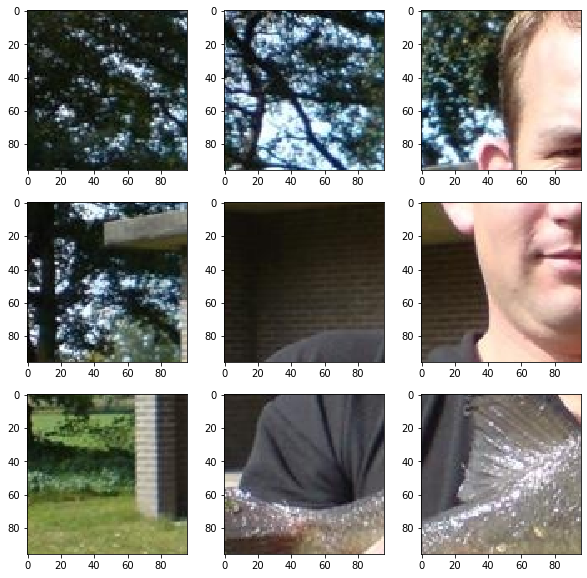

In [21]:
img = cv2.imread("img/fish.JPEG")
batches = samplePatch(img)
fig = plt.figure(figsize=(10,10))
count = 0

fig.add_subplot(3,3,1)
plt.imshow(cv2.cvtColor(batches[0:9][0][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,2)
plt.imshow(cv2.cvtColor(batches[0:9][3][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,3)
plt.imshow(cv2.cvtColor(batches[0:9][6][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,4)
plt.imshow(cv2.cvtColor(batches[0:9][1][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,5)
plt.imshow(cv2.cvtColor(batches[0:9][1][0], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,6)
plt.imshow(cv2.cvtColor(batches[0:9][7][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,7)
plt.imshow(cv2.cvtColor(batches[0:9][2][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,8)
plt.imshow(cv2.cvtColor(batches[0:9][5][1], cv2.COLOR_BGR2RGB))
fig.add_subplot(3,3,9)
plt.imshow(cv2.cvtColor(batches[0:9][8][1], cv2.COLOR_BGR2RGB))